In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras import backend as K, metrics
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()
n = 2
multiTrack = False
context, x_train, labels = data.import_data(data.init(), n, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.3333333333333333
 >> Context(max_t=3.0, dt=0.02, n_instances=150, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = False
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.994791666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9947916666666665
 |>  150


In [137]:
n = 100
min_f = 3
max_f = 15
# x_train = g.gen_data(context, n, max_f=max_f, min_f=min_f)
x_train = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f, multiTrack=multiTrack)
y_train = x_train
x_test = x_train[-10:]
x_train = x_train[:-10]

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0187499999999963
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.992708333333332
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0020833333333345
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9937500000000017
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9927083333333355
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.015625
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9937500000000026
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.99479166666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0041666666666664
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.9927083333333373
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0187500000000025
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.022916666666668
 |>  150
 [DEBUG] > 
 |>  t

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0291666666666703
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.993749999999999
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.0083333333333364
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.99166666666667
 |>  150
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  3.001041666666668
 |>  150


In [138]:
x_train.shape

(267, 150, 1)

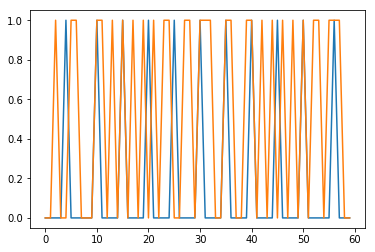

In [141]:
plt.plot(x_train[0,:60])
plt.plot(x_train[1,:60])

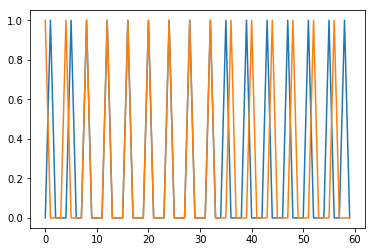

In [143]:
plt.plot(x_train[2,:60])
plt.plot(x_train[3,:60])

In [144]:
x_train.shape

(267, 150, 1)

In [145]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train.shape[1:] # shape of a single sample
# output_length = y_train.shape[1:][0]
input_shape

(150, 1)

In [146]:
output_shape

(150, 1)

In [147]:
num_encoder_tokens = x_train.shape[-1]
num_decoder_tokens = y_train.shape[-1]
# latent_dim = 1

In [148]:
k_reg = regularizers.l2(0.01) # 10e-5
# b_reg = regularizers.l1(0.01)
a_reg = regularizers.l1(0.01) # 10e-5

In [149]:
input_shape
# input_shape = (150,)
input_shape

(150, 1)

In [150]:
batch_size = 32
original_dim = 150
latent_dim = 3
intermediate_dim = 150
epsilon_std = 1.0

In [151]:
# TODO Batch Normalization

In [152]:
def sampling(args, latent_dim, epsilon_std):
    z_mean, z_log_var = args
    # epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [164]:
k_reg = regularizers.l2(1e-5)
# b_reg = regularizers.l1(0.01)
a_reg = regularizers.l1(1e-5)

def encoder(latent_dim, input_shape, intermediate_dim = 150):
    encoder_input = Input(shape=input_shape, name='encoder_input-')
    h = encoder_input
    # image_data_format = 'channels_last'   -   e.g. (28,28,3)
    # naive assumption:
    #   for drumkits no correlation between note_indices and occurrence at an timestep is assumed
    #   (that is, p(E|C) is not significantly different from p(D|C))
    #   - note that this _is_ the case for e.g. HH vs. OH
    #     these often occur in the same register (between different drumkits)
    #   - even with melodic/harmonic data, this assumption could help by reducing
    #    (1) unwanted repetition (stuttering) of notes
    #    (2) unwanted dissonance (caused by playing notes with an interval of a half step)
    
    timesteps = input_shape[-2]
    notes = input_shape[-1]
    
    # Convolve & Pool
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)

    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='relu', padding='same')(h)
    h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)
    
#     h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
#     h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     h = MaxPooling1D(pool_size=2, strides=2, padding='same')(h)
#     # 128 512

    # Dense layers
    h = Flatten()(h)
    h = Dense(intermediate_dim, activation='relu')(h)
#     h = Dropout(0.1)(h) # uncomment when using larger batches
    h = Dense(intermediate_dim, activation='relu')(h)
    # h = Dense(intermediate_dim, activation='relu', kernel_regularizer=k_reg, activity_regularizer=a_reg)(h)

    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
    
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, z_mean, z_log_var, encoder_input

def z_(latent_dim, epsilon_std):
    # sample z from a distribution defined by [input_mean, input_log_var]
    # input :: [z_mean, z_log_var]
    z_input = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
    sampling_ = lambda args: sampling(args, latent_dim, epsilon_std)
    z_output = Lambda(sampling_, name='z_sampler-')(z_input)
    # z_output = Lambda(sampling_, output_shape=(latent_dim,), name='z_sampler-')(z_input)
    z_model = Model(z_input, z_output, name='z_model-')
    return z_model

def decoder(latent_dim, output_shape, filters = 32):
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    
    timesteps = output_shape[-2] # cols
    notes = output_shape[-1] # rows
    channels = 1 # rgb

    # image_data_format = 'channels_last'
    output_shape = (timesteps, notes, channels)
    
    z_input = Input(shape=(latent_dim,), name='decoder_input-')
    h = z_input
    # upsampling
    h = Dense(np.prod(output_shape[-3:]), activation='relu')(h)
    h = Reshape(output_shape[-3:])(h)
    
    # Convolve & Pool
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    h = Conv2DTranspose(32, kernel_size=k, strides=1, activation='relu', padding='same')(h)
    h = Conv2DTranspose(32, kernel_size=k, strides=s, activation='relu', padding='same')(h)
    h = Conv2DTranspose(64, kernel_size=k, strides=1, activation='relu', padding='same')(h)
    # Mean (output)
    h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    
    output_shape = (timesteps, notes)
    h = Reshape(output_shape)(h)
    decoder_output = h
    model = Model(inputs=z_input, outputs=decoder_output, name='decoder_model-')
    return model

In [165]:
encoder_model, z_mean, z_log_var, encoder_input = encoder(latent_dim, input_shape)
z_model = z_(latent_dim, epsilon_std)
decoder_model = decoder(latent_dim, output_shape)


encoder_model.summary()
z_model.summary()
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
conv1d_55 (Conv1D)              (None, 75, 32)       96          encoder_input-[0][0]             
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 75, 32)       2080        conv1d_55[0][0]                  
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 75, 32)       2080        conv1d_56[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [166]:
vae_input = Input(shape=input_shape)
# vae_input = Input(shape=(150,1))
vae_input = encoder_input # WHY ?
vae_output = decoder_model(z_model(encoder_model(vae_input)))
# vae_output = decoder_model(z)
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input- (InputLayer)     (None, 150, 1)       0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 3), (None, 3 210362      encoder_input-[0][0]             
__________________________________________________________________________________________________
z_model- (Model)                (None, 3)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
decoder_model- (Model)          (None, 150, 1)       16473       z_model-[1][0]                   
Total para

In [156]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    # img_rows * img_cols
    # xent_loss = K.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
    xent_loss = K.binary_crossentropy(y_true, y_pred)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # kl_loss = - 0.5 * K.sum(1 + K.flatten(z_log_var) - K.square(K.flatten(z_mean)) - K.exp(K.flatten(z_log_var)), axis=-1)
    return xent_loss + kl_loss

In [157]:
metrics = ['acc','mse','mae']
# loss = 'binary_crossentropy'#  sparse_categorical_crossentropy
loss = lambda y_true, y_pred: vae_loss(y_true, y_pred, z_mean, z_log_var)
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [158]:
# vae.add_loss(vae_loss)
# vae.compile(optimizer='rmsprop', metrics=['binary_accuracy','mae'])

In [159]:
# z_train = x_train
# x_train = x_train.reshape(x_train.shape[0],np.prod(x_train.shape[1:]))
x_train.shape

(267, 150, 1)

In [160]:
epochs = 300
m = int(64*2 * 7/6)
vs = 1/6
shuffle = True
callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
history = vae.fit(x_train[:m], x_train[:m], epochs=epochs, batch_size=batch_size,
          validation_split=vs, callbacks=callbacks, shuffle=shuffle)
# history = vae.fit(x_train[:m], shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 126 samples, validate on 18 samples
Epoch 1/500
126/126 [==============================] - 1s 8ms/step - loss: 0.6885 - acc: 0.6657 - mean_squared_error: 0.2469 - mean_absolute_error: 0.4969 - val_loss: 0.6786 - val_acc: 0.7178 - val_mean_squared_error: 0.2427 - val_mean_absolute_error: 0.4924
Epoch 2/500
126/126 [==============================] - 0s 3ms/step - loss: 0.6679 - acc: 0.7598 - mean_squared_error: 0.2373 - mean_absolute_error: 0.4866 - val_loss: 0.6620 - val_acc: 0.7178 - val_mean_squared_error: 0.2343 - val_mean_absolute_error: 0.4827
Epoch 3/500
126/126 [==============================] - 0s 3ms/step - loss: 0.6472 - acc: 0.7598 - mean_squared_error: 0.2266 - mean_absolute_error: 0.4740 - val_loss: 0.6443 - val_acc: 0.7178 - val_mean_squared_error: 0.2250 - val_mean_absolute_error: 0.4703
Epoch 4/500
126/126 [==============================] - 0s 3ms/step - loss: 0.6250 - acc: 0.7598 - mean_squared_error: 0.2151 - mean_absolute_error: 0.4585 - val_loss: 0.6332 - va

126/126 [==============================] - 0s 3ms/step - loss: 0.9272 - acc: 0.7598 - mean_squared_error: 0.1772 - mean_absolute_error: 0.3526 - val_loss: 1.0504 - val_acc: 0.7178 - val_mean_squared_error: 0.1972 - val_mean_absolute_error: 0.3816
Epoch 33/500
126/126 [==============================] - 0s 3ms/step - loss: 1.0199 - acc: 0.7598 - mean_squared_error: 0.1765 - mean_absolute_error: 0.3519 - val_loss: 0.9814 - val_acc: 0.7178 - val_mean_squared_error: 0.1989 - val_mean_absolute_error: 0.3824
Epoch 34/500
126/126 [==============================] - 0s 3ms/step - loss: 0.9885 - acc: 0.7598 - mean_squared_error: 0.1763 - mean_absolute_error: 0.3505 - val_loss: 0.9951 - val_acc: 0.7178 - val_mean_squared_error: 0.1940 - val_mean_absolute_error: 0.3762
Epoch 35/500
126/126 [==============================] - 0s 3ms/step - loss: 0.9757 - acc: 0.7598 - mean_squared_error: 0.1758 - mean_absolute_error: 0.3521 - val_loss: 0.9851 - val_acc: 0.7178 - val_mean_squared_error: 0.1962 - val_m

126/126 [==============================] - 0s 3ms/step - loss: 1.0024 - acc: 0.7598 - mean_squared_error: 0.1729 - mean_absolute_error: 0.3477 - val_loss: 1.2042 - val_acc: 0.7178 - val_mean_squared_error: 0.1930 - val_mean_absolute_error: 0.3633
Epoch 64/500
126/126 [==============================] - 0s 3ms/step - loss: 1.0879 - acc: 0.7598 - mean_squared_error: 0.1723 - mean_absolute_error: 0.3429 - val_loss: 1.0478 - val_acc: 0.7178 - val_mean_squared_error: 0.1913 - val_mean_absolute_error: 0.3645
Epoch 65/500
126/126 [==============================] - 0s 3ms/step - loss: 1.0511 - acc: 0.7598 - mean_squared_error: 0.1731 - mean_absolute_error: 0.3426 - val_loss: 1.0164 - val_acc: 0.7178 - val_mean_squared_error: 0.1917 - val_mean_absolute_error: 0.3897
Epoch 66/500
126/126 [==============================] - 0s 3ms/step - loss: 1.0785 - acc: 0.7598 - mean_squared_error: 0.1731 - mean_absolute_error: 0.3480 - val_loss: 1.0097 - val_acc: 0.7178 - val_mean_squared_error: 0.1939 - val_m

126/126 [==============================] - 0s 3ms/step - loss: 1.0694 - acc: 0.7598 - mean_squared_error: 0.1717 - mean_absolute_error: 0.3417 - val_loss: 1.0531 - val_acc: 0.7178 - val_mean_squared_error: 0.1903 - val_mean_absolute_error: 0.3802
Epoch 95/500
126/126 [==============================] - 0s 3ms/step - loss: 1.0407 - acc: 0.7598 - mean_squared_error: 0.1713 - mean_absolute_error: 0.3410 - val_loss: 1.0110 - val_acc: 0.7178 - val_mean_squared_error: 0.1911 - val_mean_absolute_error: 0.3827
Epoch 96/500
126/126 [==============================] - 0s 3ms/step - loss: 1.1059 - acc: 0.7598 - mean_squared_error: 0.1722 - mean_absolute_error: 0.3397 - val_loss: 1.0161 - val_acc: 0.7178 - val_mean_squared_error: 0.1903 - val_mean_absolute_error: 0.3899
Epoch 97/500
126/126 [==============================] - 0s 3ms/step - loss: 1.0891 - acc: 0.7598 - mean_squared_error: 0.1733 - mean_absolute_error: 0.3439 - val_loss: 1.1673 - val_acc: 0.7178 - val_mean_squared_error: 0.1911 - val_m

126/126 [==============================] - 0s 3ms/step - loss: 3.4013 - acc: 0.7594 - mean_squared_error: 0.1928 - mean_absolute_error: 0.3052 - val_loss: 2.6011 - val_acc: 0.7111 - val_mean_squared_error: 0.2177 - val_mean_absolute_error: 0.3481
Epoch 126/500
126/126 [==============================] - 0s 3ms/step - loss: 3.5883 - acc: 0.7613 - mean_squared_error: 0.1946 - mean_absolute_error: 0.2999 - val_loss: 2.3116 - val_acc: 0.7011 - val_mean_squared_error: 0.2129 - val_mean_absolute_error: 0.3578
Epoch 127/500
126/126 [==============================] - 0s 3ms/step - loss: 3.8300 - acc: 0.7574 - mean_squared_error: 0.1974 - mean_absolute_error: 0.3019 - val_loss: 2.3193 - val_acc: 0.6978 - val_mean_squared_error: 0.2090 - val_mean_absolute_error: 0.3587
Epoch 128/500
126/126 [==============================] - 0s 3ms/step - loss: 3.8016 - acc: 0.7586 - mean_squared_error: 0.1974 - mean_absolute_error: 0.3010 - val_loss: 3.2695 - val_acc: 0.7119 - val_mean_squared_error: 0.2228 - va

126/126 [==============================] - 1s 5ms/step - loss: 59.5993 - acc: 0.7289 - mean_squared_error: 0.2386 - mean_absolute_error: 0.2722 - val_loss: 49.8980 - val_acc: 0.6937 - val_mean_squared_error: 0.2687 - val_mean_absolute_error: 0.3065
Epoch 157/500
126/126 [==============================] - 1s 4ms/step - loss: 62.6943 - acc: 0.7295 - mean_squared_error: 0.2404 - mean_absolute_error: 0.2717 - val_loss: 59.7346 - val_acc: 0.6919 - val_mean_squared_error: 0.2786 - val_mean_absolute_error: 0.3072
Epoch 158/500
126/126 [==============================] - 1s 6ms/step - loss: 71.9689 - acc: 0.7309 - mean_squared_error: 0.2403 - mean_absolute_error: 0.2694 - val_loss: 64.5140 - val_acc: 0.6952 - val_mean_squared_error: 0.2716 - val_mean_absolute_error: 0.3047
Epoch 159/500
126/126 [==============================] - 1s 5ms/step - loss: 77.6600 - acc: 0.7325 - mean_squared_error: 0.2428 - mean_absolute_error: 0.2702 - val_loss: 65.7119 - val_acc: 0.6989 - val_mean_squared_error: 0.2

126/126 [==============================] - 1s 4ms/step - loss: 167.7378 - acc: 0.7535 - mean_squared_error: 0.2386 - mean_absolute_error: 0.2476 - val_loss: 163.6662 - val_acc: 0.7163 - val_mean_squared_error: 0.2793 - val_mean_absolute_error: 0.2853
Epoch 188/500
126/126 [==============================] - 1s 4ms/step - loss: 177.3809 - acc: 0.7533 - mean_squared_error: 0.2382 - mean_absolute_error: 0.2467 - val_loss: 96.5924 - val_acc: 0.7100 - val_mean_squared_error: 0.2827 - val_mean_absolute_error: 0.2912
Epoch 189/500
126/126 [==============================] - 1s 4ms/step - loss: 158.3125 - acc: 0.7520 - mean_squared_error: 0.2408 - mean_absolute_error: 0.2489 - val_loss: 134.7850 - val_acc: 0.7111 - val_mean_squared_error: 0.2825 - val_mean_absolute_error: 0.2886
Epoch 190/500
126/126 [==============================] - 0s 4ms/step - loss: 397.4004 - acc: 0.7511 - mean_squared_error: 0.2430 - mean_absolute_error: 0.2490 - val_loss: 107.8061 - val_acc: 0.7115 - val_mean_squared_err

Epoch 218/500
126/126 [==============================] - 0s 3ms/step - loss: 524.6594 - acc: 0.7555 - mean_squared_error: 0.2417 - mean_absolute_error: 0.2449 - val_loss: 387.9370 - val_acc: 0.7122 - val_mean_squared_error: 0.2852 - val_mean_absolute_error: 0.2894
Epoch 219/500
126/126 [==============================] - 0s 3ms/step - loss: 453.9929 - acc: 0.7530 - mean_squared_error: 0.2435 - mean_absolute_error: 0.2470 - val_loss: 366.8132 - val_acc: 0.7126 - val_mean_squared_error: 0.2838 - val_mean_absolute_error: 0.2880
Epoch 220/500
126/126 [==============================] - 0s 4ms/step - loss: 384.3710 - acc: 0.7546 - mean_squared_error: 0.2423 - mean_absolute_error: 0.2461 - val_loss: 333.4470 - val_acc: 0.7070 - val_mean_squared_error: 0.2887 - val_mean_absolute_error: 0.2920
Epoch 221/500
126/126 [==============================] - 0s 4ms/step - loss: 403.5078 - acc: 0.7553 - mean_squared_error: 0.2423 - mean_absolute_error: 0.2454 - val_loss: 284.7630 - val_acc: 0.7111 - val_m

Epoch 249/500
126/126 [==============================] - 0s 3ms/step - loss: 132.6044 - acc: 0.7575 - mean_squared_error: 0.2415 - mean_absolute_error: 0.2423 - val_loss: 149.0463 - val_acc: 0.7159 - val_mean_squared_error: 0.2829 - val_mean_absolute_error: 0.2837
Epoch 250/500
126/126 [==============================] - 0s 3ms/step - loss: 112.3270 - acc: 0.7572 - mean_squared_error: 0.2418 - mean_absolute_error: 0.2425 - val_loss: 118.8886 - val_acc: 0.7167 - val_mean_squared_error: 0.2821 - val_mean_absolute_error: 0.2831
Epoch 251/500
126/126 [==============================] - 0s 3ms/step - loss: 76.3919 - acc: 0.7583 - mean_squared_error: 0.2411 - mean_absolute_error: 0.2418 - val_loss: 71.8271 - val_acc: 0.7152 - val_mean_squared_error: 0.2843 - val_mean_absolute_error: 0.2849
Epoch 252/500
126/126 [==============================] - 1s 5ms/step - loss: 62.1798 - acc: 0.7573 - mean_squared_error: 0.2419 - mean_absolute_error: 0.2425 - val_loss: 68.1148 - val_acc: 0.7144 - val_mean_

126/126 [==============================] - 0s 3ms/step - loss: 143.8448 - acc: 0.7593 - mean_squared_error: 0.2404 - mean_absolute_error: 0.2408 - val_loss: 106.2856 - val_acc: 0.7159 - val_mean_squared_error: 0.2831 - val_mean_absolute_error: 0.2838
Epoch 281/500
126/126 [==============================] - 0s 3ms/step - loss: 93.7535 - acc: 0.7594 - mean_squared_error: 0.2403 - mean_absolute_error: 0.2406 - val_loss: 99.9687 - val_acc: 0.7174 - val_mean_squared_error: 0.2823 - val_mean_absolute_error: 0.2828
Epoch 282/500
126/126 [==============================] - 0s 3ms/step - loss: 77.6704 - acc: 0.7596 - mean_squared_error: 0.2402 - mean_absolute_error: 0.2404 - val_loss: 58.1817 - val_acc: 0.7181 - val_mean_squared_error: 0.2817 - val_mean_absolute_error: 0.2820
Epoch 283/500
126/126 [==============================] - 0s 3ms/step - loss: 59.1313 - acc: 0.7593 - mean_squared_error: 0.2405 - mean_absolute_error: 0.2408 - val_loss: 49.9353 - val_acc: 0.7170 - val_mean_squared_error: 0

126/126 [==============================] - 0s 3ms/step - loss: 53.7484 - acc: 0.7594 - mean_squared_error: 0.2403 - mean_absolute_error: 0.2406 - val_loss: 36.3632 - val_acc: 0.7174 - val_mean_squared_error: 0.2824 - val_mean_absolute_error: 0.2827
Epoch 312/500
126/126 [==============================] - 0s 3ms/step - loss: 61.1398 - acc: 0.7588 - mean_squared_error: 0.2408 - mean_absolute_error: 0.2412 - val_loss: 122.9912 - val_acc: 0.7167 - val_mean_squared_error: 0.2827 - val_mean_absolute_error: 0.2831
Epoch 313/500
126/126 [==============================] - 0s 3ms/step - loss: 105.9340 - acc: 0.7593 - mean_squared_error: 0.2403 - mean_absolute_error: 0.2407 - val_loss: 108.3009 - val_acc: 0.7167 - val_mean_squared_error: 0.2829 - val_mean_absolute_error: 0.2837
Epoch 314/500
126/126 [==============================] - 0s 3ms/step - loss: 146.4998 - acc: 0.7591 - mean_squared_error: 0.2405 - mean_absolute_error: 0.2411 - val_loss: 104.5826 - val_acc: 0.7156 - val_mean_squared_error

Epoch 342/500
126/126 [==============================] - 1s 4ms/step - loss: 472.8084 - acc: 0.7579 - mean_squared_error: 0.2418 - mean_absolute_error: 0.2421 - val_loss: 409.4369 - val_acc: 0.7185 - val_mean_squared_error: 0.2814 - val_mean_absolute_error: 0.2819
Epoch 343/500
126/126 [==============================] - 1s 4ms/step - loss: 520.5226 - acc: 0.7588 - mean_squared_error: 0.2410 - mean_absolute_error: 0.2414 - val_loss: 380.1608 - val_acc: 0.7156 - val_mean_squared_error: 0.2841 - val_mean_absolute_error: 0.2843
Epoch 344/500
126/126 [==============================] - 0s 4ms/step - loss: 546.3744 - acc: 0.7580 - mean_squared_error: 0.2417 - mean_absolute_error: 0.2419 - val_loss: 409.0693 - val_acc: 0.7178 - val_mean_squared_error: 0.2817 - val_mean_absolute_error: 0.2821
Epoch 345/500
126/126 [==============================] - 1s 4ms/step - loss: 564.2154 - acc: 0.7587 - mean_squared_error: 0.2408 - mean_absolute_error: 0.2412 - val_loss: 345.8475 - val_acc: 0.7185 - val_m

Epoch 373/500
126/126 [==============================] - 0s 4ms/step - loss: 129.1663 - acc: 0.7591 - mean_squared_error: 0.2407 - mean_absolute_error: 0.2409 - val_loss: 175.5569 - val_acc: 0.7181 - val_mean_squared_error: 0.2819 - val_mean_absolute_error: 0.2821
Epoch 374/500
126/126 [==============================] - 0s 4ms/step - loss: 126.6476 - acc: 0.7597 - mean_squared_error: 0.2401 - mean_absolute_error: 0.2404 - val_loss: 108.6181 - val_acc: 0.7185 - val_mean_squared_error: 0.2811 - val_mean_absolute_error: 0.2815
Epoch 375/500
126/126 [==============================] - 0s 3ms/step - loss: 193.3395 - acc: 0.7589 - mean_squared_error: 0.2408 - mean_absolute_error: 0.2411 - val_loss: 92.6144 - val_acc: 0.7152 - val_mean_squared_error: 0.2839 - val_mean_absolute_error: 0.2843
Epoch 376/500
126/126 [==============================] - 0s 3ms/step - loss: 236.9916 - acc: 0.7586 - mean_squared_error: 0.2411 - mean_absolute_error: 0.2413 - val_loss: 122.0658 - val_acc: 0.7178 - val_me

Epoch 404/500
126/126 [==============================] - 0s 3ms/step - loss: 267.4464 - acc: 0.7593 - mean_squared_error: 0.2404 - mean_absolute_error: 0.2407 - val_loss: 204.5886 - val_acc: 0.7181 - val_mean_squared_error: 0.2816 - val_mean_absolute_error: 0.2818
Epoch 405/500
126/126 [==============================] - 0s 3ms/step - loss: 191.1201 - acc: 0.7597 - mean_squared_error: 0.2401 - mean_absolute_error: 0.2403 - val_loss: 152.3610 - val_acc: 0.7181 - val_mean_squared_error: 0.2813 - val_mean_absolute_error: 0.2817
Epoch 406/500
126/126 [==============================] - 0s 4ms/step - loss: 227.1997 - acc: 0.7596 - mean_squared_error: 0.2402 - mean_absolute_error: 0.2404 - val_loss: 164.2133 - val_acc: 0.7189 - val_mean_squared_error: 0.2809 - val_mean_absolute_error: 0.2813
Epoch 407/500
126/126 [==============================] - 0s 4ms/step - loss: 192.2311 - acc: 0.7596 - mean_squared_error: 0.2402 - mean_absolute_error: 0.2404 - val_loss: 155.7197 - val_acc: 0.7181 - val_m

Epoch 435/500
126/126 [==============================] - 0s 3ms/step - loss: 1823.0425 - acc: 0.7573 - mean_squared_error: 0.2425 - mean_absolute_error: 0.2427 - val_loss: 2318.3779 - val_acc: 0.7178 - val_mean_squared_error: 0.2822 - val_mean_absolute_error: 0.2822
Epoch 436/500
126/126 [==============================] - 0s 3ms/step - loss: 2335.4833 - acc: 0.7581 - mean_squared_error: 0.2418 - mean_absolute_error: 0.2419 - val_loss: 1290.7144 - val_acc: 0.7178 - val_mean_squared_error: 0.2821 - val_mean_absolute_error: 0.2821
Epoch 437/500
126/126 [==============================] - 0s 3ms/step - loss: 1706.0266 - acc: 0.7590 - mean_squared_error: 0.2407 - mean_absolute_error: 0.2409 - val_loss: 1046.6614 - val_acc: 0.7152 - val_mean_squared_error: 0.2847 - val_mean_absolute_error: 0.2849
Epoch 438/500
126/126 [==============================] - 0s 3ms/step - loss: 2336.0436 - acc: 0.7583 - mean_squared_error: 0.2417 - mean_absolute_error: 0.2418 - val_loss: 1524.1475 - val_acc: 0.7178

Epoch 466/500
126/126 [==============================] - 0s 3ms/step - loss: 292.0342 - acc: 0.7597 - mean_squared_error: 0.2400 - mean_absolute_error: 0.2402 - val_loss: 441.3264 - val_acc: 0.7181 - val_mean_squared_error: 0.2815 - val_mean_absolute_error: 0.2822
Epoch 467/500
126/126 [==============================] - 0s 3ms/step - loss: 329.3558 - acc: 0.7592 - mean_squared_error: 0.2403 - mean_absolute_error: 0.2406 - val_loss: 595.8594 - val_acc: 0.7170 - val_mean_squared_error: 0.2829 - val_mean_absolute_error: 0.2830
Epoch 468/500
126/126 [==============================] - 0s 3ms/step - loss: 384.3978 - acc: 0.7597 - mean_squared_error: 0.2402 - mean_absolute_error: 0.2404 - val_loss: 518.7898 - val_acc: 0.7156 - val_mean_squared_error: 0.2842 - val_mean_absolute_error: 0.2845
Epoch 469/500
126/126 [==============================] - 0s 3ms/step - loss: 401.3313 - acc: 0.7589 - mean_squared_error: 0.2409 - mean_absolute_error: 0.2411 - val_loss: 531.8716 - val_acc: 0.7178 - val_m

Epoch 497/500
126/126 [==============================] - 0s 3ms/step - loss: 306.3823 - acc: 0.7599 - mean_squared_error: 0.2399 - mean_absolute_error: 0.2401 - val_loss: 311.9321 - val_acc: 0.7178 - val_mean_squared_error: 0.2819 - val_mean_absolute_error: 0.2824
Epoch 498/500
126/126 [==============================] - 0s 3ms/step - loss: 315.5817 - acc: 0.7590 - mean_squared_error: 0.2407 - mean_absolute_error: 0.2410 - val_loss: 423.4731 - val_acc: 0.7174 - val_mean_squared_error: 0.2826 - val_mean_absolute_error: 0.2826
Epoch 499/500
126/126 [==============================] - 0s 3ms/step - loss: 346.2569 - acc: 0.7601 - mean_squared_error: 0.2398 - mean_absolute_error: 0.2399 - val_loss: 286.7898 - val_acc: 0.7170 - val_mean_squared_error: 0.2827 - val_mean_absolute_error: 0.2829
Epoch 500/500
126/126 [==============================] - 0s 3ms/step - loss: 248.9920 - acc: 0.7599 - mean_squared_error: 0.2400 - mean_absolute_error: 0.2402 - val_loss: 286.3219 - val_acc: 0.7170 - val_m

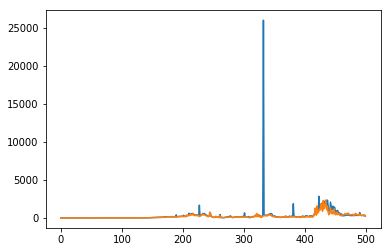

In [161]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

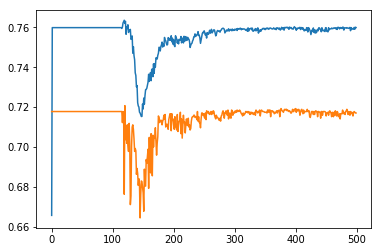

In [162]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

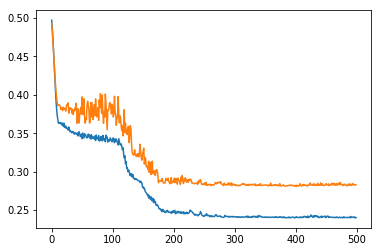

In [163]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [ ]:
# plot_model(vae, to_file='model.png')

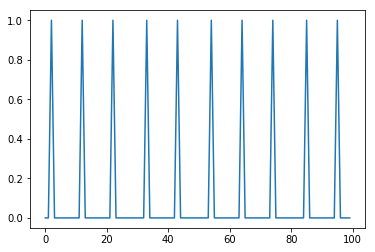

In [29]:
plt.plot(x_train[0,:100,:])

In [30]:
result.shape

NameError: name 'result' is not defined

In [ ]:
n1 = 30
i = 0
plt.subplot(211)
plt.plot(np.arange(n1), results[i][:n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)
plt.subplot(212)

plt.plot(np.arange(n1), x_train[i, :n1])
plt.plot([0.5] * n1) # midi.MIDI_NOISE_FLOOR
plt.ylim(ymin=0, ymax=1)

In [ ]:
mid = midi.decode_track(context, result)
dn = config.dataset_dir
# io.export_midifile(mid, dn + 'song_seq-seq.mid')

In [ ]:
results = []
latent_samples = []
for seq in x_test[-2:]:
    encoded = encode_sequence(np.stack([seq]))
    latent_samples.append(encoded)
    result = decode_sequence(encoded, encoder_model, decoder_model)
    results.append(result)
results[0].shape

In [ ]:
len(encoded)

In [ ]:
encoded[0].shape

In [ ]:
plt.plot(encoded[0][0,:10])
plt.plot(encoded[1][0,:10])

In [ ]:
e = np.array(latent_samples)
e.shape

In [ ]:
# reduce dimensionality
# e = e.reshape(e.shape[0],2,e.shape[-1])
e.shape

In [ ]:
e1.mean(axis=0).shape

In [ ]:
# new = e.transpose().mean(axis=1).transpose()
e1 = e[:,0] # state h
e2 = e[:,1] # state c
new = [e1.mean(axis=0), e2.mean(axis=0)]
# new = [[e[:,i].mean(axis=0)] for i in [0,1]]
plt.plot(new[0][0][:10])
len(new)

In [ ]:
e1.mean(axis=0).shape

In [ ]:
l[0].shape

In [ ]:
l = latent_samples[0]
len(l) # latent_sample :: (x,1,64)

In [ ]:
# new_ = decode_sequence(latent_samples[0], encoder_model, decoder_model)
new_ = decode_sequence(new, encoder_model, decoder_model)

In [ ]:
new_.shape

In [ ]:
plt.plot(new_[:100])

In [ ]:
plt.plot(results[0][:100])

In [ ]:
# results[0]

In [ ]:
mid_new = midi.decode_track(context, results[0])
io.export_midifile(mid_new, config.export_dir + 'real_mid_new_lstm.mid')

In [ ]:
x_test.shape

In [ ]:
# x_test, y_test = gen_xy_sin_to_f(3, f=2)

In [ ]:
results = model.predict([x_test,x_test])
results.shape

In [ ]:
# the 'true' results
i = 0
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],y_test[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
# predicted results
i = 0
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

In [ ]:
i = 0
selection = 1
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)